# Inference plot of 3 regions

In [1]:
# Import libraries
import numpy as np
import math
import branchpro
import scipy.stats
import matplotlib
import plotly.graph_objects as go
from matplotlib import pyplot as plt
import os
import pandas as pd
import datetime

In [2]:
# Read serial interval
si_file = 'si-epinow'
path = os.path.join('../data_library/serial_interval', '{}.csv'.format(si_file))
serial_interval = pd.read_csv(path, header=None)
serial_interval = serial_interval.fillna(0)
serial_intervals = serial_interval.values.T

## Ontaria data

In [3]:
# Read Ontario data
path = os.path.join('../data_library/covid_ontario/ON.csv')
data = pd.read_csv(path)[:51]

In [4]:
time_key = 'Time'
num_timepoints = max(data[time_key])
data_times = data[time_key]

# Pad with zeros the time points where we have no information on
# the number of incidences
padded_inc_data = data.set_index(time_key).reindex(
    range(
        1, max(data_times)+1)
        ).fillna(0).reset_index()
locally_infected_cases_ON = padded_inc_data['Incidence Number']
imported_cases_ON = padded_inc_data['Imported Cases']

start_times = np.arange(1, num_timepoints+1, dtype=int)
times = np.arange(num_timepoints+1)

In [5]:
tau = 6
R_t_start = tau+1
a = 1
b = 0.2

# Run inferences for different values of epsilon
column_names = ['Time Points', 'Mean', 'Lower bound CI', 'Upper bound CI', 'Central Probability', 'Epsilon']
epsilon_range = [0.25, 1, 2]
chosen_times = [10, 15, 20, 25, 30, 40]

all_intervals = pd.DataFrame(columns=column_names)
all_intervals_chosen = pd.DataFrame(columns=column_names)
# Transform our incidence data into pandas dataframes
inc_data = pd.DataFrame(
    {
        'Time': start_times,
        'Incidence Number': locally_infected_cases_ON
    }
)

imported_inc_data = pd.DataFrame(
    {
        'Time': start_times,
        'Incidence Number': imported_cases_ON
    }
)

for epsilon in epsilon_range:
    inference = branchpro.LocImpBranchProPosteriorMultSI(
        inc_data=inc_data,
        imported_inc_data=imported_inc_data,
        epsilon=epsilon,
        daily_serial_intervals=serial_intervals,
        alpha=a,
        beta=b)

    inference.run_inference(tau=tau)
    intervals = inference.get_intervals(central_prob=0)
    intervals = intervals.append(inference.get_intervals(central_prob=.25))
    intervals = intervals.append(inference.get_intervals(central_prob=.95))
    temp = inference.get_intervals(central_prob=.95)

    intervals['Epsilon'] = [epsilon] * len(intervals.index)

    intervals_chosen = pd.DataFrame(columns=intervals.columns)
    for time_pt in chosen_times:
        intervals_chosen = intervals_chosen.append(
            intervals.loc[intervals['Time Points']== time_pt])

    all_intervals = all_intervals.append(intervals)
    all_intervals_chosen = all_intervals_chosen.append(intervals_chosen)

In [6]:
inference_times = sorted(list(set(all_intervals['Time Points'].tolist())))
all_intervals_ON = all_intervals[all_intervals['Central Probability']==0.95]

## New South Wales data

In [7]:
# Read New South Wales data
path = os.path.join('../data_library/covid_australia/NSW.csv')
data = pd.read_csv(path)[:51]

time_key = 'Time'
num_timepoints = max(data[time_key])
data_times = data[time_key]

# Pad with zeros the time points where we have no information on
# the number of incidences
padded_inc_data = data.set_index(time_key).reindex(
    range(
        1, max(data_times)+1)
        ).fillna(0).reset_index()
locally_infected_cases_NSW = padded_inc_data['Incidence Number']
imported_cases_NSW = padded_inc_data['Imported Cases']

start_times = np.arange(1, num_timepoints+1, dtype=int)
times = np.arange(num_timepoints+1)

In [8]:
# Run inferences for different values of epsilon
column_names = ['Time Points', 'Mean', 'Lower bound CI', 'Upper bound CI', 'Central Probability', 'Epsilon']
epsilon_range = [0.25, 1, 2]
chosen_times = [10, 15, 20, 25, 30, 40]

all_intervals = pd.DataFrame(columns=column_names)
all_intervals_chosen = pd.DataFrame(columns=column_names)
# Transform our incidence data into pandas dataframes
inc_data = pd.DataFrame(
    {
        'Time': start_times,
        'Incidence Number': locally_infected_cases_NSW
    }
)

imported_inc_data = pd.DataFrame(
    {
        'Time': start_times,
        'Incidence Number': imported_cases_NSW
    }
)

for epsilon in epsilon_range:
    inference = branchpro.LocImpBranchProPosteriorMultSI(
        inc_data=inc_data,
        imported_inc_data=imported_inc_data,
        epsilon=epsilon,
        daily_serial_intervals=serial_intervals,
        alpha=a,
        beta=b)

    inference.run_inference(tau=tau)
    intervals = inference.get_intervals(central_prob=0)
    intervals = intervals.append(inference.get_intervals(central_prob=.25))
    intervals = intervals.append(inference.get_intervals(central_prob=.95))
    temp = inference.get_intervals(central_prob=.95)

    intervals['Epsilon'] = [epsilon] * len(intervals.index)

    intervals_chosen = pd.DataFrame(columns=intervals.columns)
    for time_pt in chosen_times:
        intervals_chosen = intervals_chosen.append(
            intervals.loc[intervals['Time Points']== time_pt])

    all_intervals = all_intervals.append(intervals)
    all_intervals_chosen = all_intervals_chosen.append(intervals_chosen)

In [9]:
inference_times = sorted(list(set(all_intervals['Time Points'].tolist())))
all_intervals_NSW = all_intervals[all_intervals['Central Probability']==0.95]

## Victoria data

In [10]:
# Read Victoria data
path = os.path.join('../data_library/covid_australia/VIC.csv')
data = pd.read_csv(path)[:51]

time_key = 'Time'
num_timepoints = max(data[time_key])
data_times = data[time_key]

# Pad with zeros the time points where we have no information on
# the number of incidences
padded_inc_data = data.set_index(time_key).reindex(
    range(
        1, max(data_times)+1)
        ).fillna(0).reset_index()
locally_infected_cases_VIC = padded_inc_data['Incidence Number']
imported_cases_VIC = padded_inc_data['Imported Cases']

start_times = np.arange(1, num_timepoints+1, dtype=int)
times = np.arange(num_timepoints+1)

# Run inferences for different values of epsilon
column_names = ['Time Points', 'Mean', 'Lower bound CI', 'Upper bound CI', 'Central Probability', 'Epsilon']
epsilon_range = [0.25, 1, 2]
chosen_times = [10, 15, 20, 25, 30, 40]

all_intervals = pd.DataFrame(columns=column_names)
all_intervals_chosen = pd.DataFrame(columns=column_names)
# Transform our incidence data into pandas dataframes
inc_data = pd.DataFrame(
    {
        'Time': start_times,
        'Incidence Number': locally_infected_cases_VIC
    }
)

imported_inc_data = pd.DataFrame(
    {
        'Time': start_times,
        'Incidence Number': imported_cases_VIC
    }
)

for epsilon in epsilon_range:
    inference = branchpro.LocImpBranchProPosteriorMultSI(
        inc_data=inc_data,
        imported_inc_data=imported_inc_data,
        epsilon=epsilon,
        daily_serial_intervals=serial_intervals,
        alpha=a,
        beta=b)

    inference.run_inference(tau=tau)
    intervals = inference.get_intervals(central_prob=0)
    intervals = intervals.append(inference.get_intervals(central_prob=.25))
    intervals = intervals.append(inference.get_intervals(central_prob=.95))
    temp = inference.get_intervals(central_prob=.95)

    intervals['Epsilon'] = [epsilon] * len(intervals.index)

    intervals_chosen = pd.DataFrame(columns=intervals.columns)
    for time_pt in chosen_times:
        intervals_chosen = intervals_chosen.append(
            intervals.loc[intervals['Time Points']== time_pt])

    all_intervals = all_intervals.append(intervals)
    all_intervals_chosen = all_intervals_chosen.append(intervals_chosen)
    
prior_dist = scipy.stats.gamma(a, scale=1/b)

inference_times = sorted(list(set(all_intervals['Time Points'].tolist())))
epsilon_range = [0.25, 1, 2]
all_intervals_VIC = all_intervals[all_intervals['Central Probability']==0.95]

## Combine inference plots

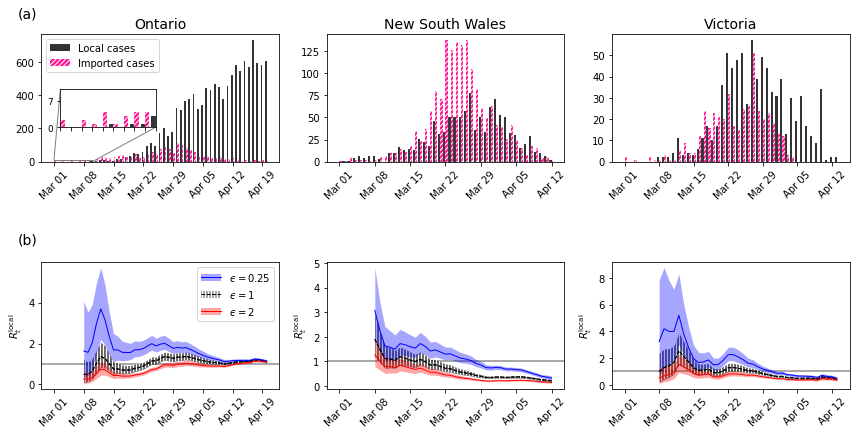

In [15]:
fig = branchpro.figures.plot_regions_inference(
    datetime.datetime(2020, 3, 1),
    ['Ontario', 'New South Wales', 'Victoria'],
    [locally_infected_cases_ON, locally_infected_cases_NSW, locally_infected_cases_VIC],
    [imported_cases_ON, imported_cases_NSW, imported_cases_VIC],
    datetime.datetime(2020, 3, 1) + datetime.timedelta(days=inference_times[0]-1),
    list(epsilon_range),
    [[all_intervals_ON.loc[all_intervals_ON['Epsilon']==eps] for eps in epsilon_range],
    [all_intervals_NSW.loc[all_intervals_NSW['Epsilon']==eps] for eps in epsilon_range],
    [all_intervals_VIC.loc[all_intervals_VIC['Epsilon']==eps] for eps in epsilon_range]],
    default_epsilon=1,
    inset_region=['Ontario'],
    show=False)

plt.savefig('combined_inference.pdf')